In [1]:
from scipy.io import readsav
import netCDF4 as nc
import matplotlib.pyplot as plt
plt.style.use(["science", "ieee"])

size=12
import matplotlib as mpl
mpl.rcParams.update({"xtick.labelsize": size, "ytick.labelsize":size, "font.size":size})
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Tahoma", "DejaVu Sans",
                                   "Lucida Grande", "Verdana"]
import datetime as dt
import pandas as pd
import numpy as np

%matplotlib inline
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

import os
import requests


Bad key "text.kerning_factor" on line 4 in
/home/shibaji/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def fetch_one_day_files(date):
    url = f"http://guvitimed.jhuapl.edu/tools/php/data_fetch.php?p=sl1b_spectV13&y={date.year}&d={date.timetuple().tm_yday}"
    r = requests.get(url)
    if r.status_code == 200:
        files = [f for f in r.text.split(",") if ".nc" in f]
        
    source = f"database/GUVI/L1BSpec/{date.strftime('%Y-%m-%d')}/"
    os.makedirs(source, exist_ok=True)
    uri = "http://guvitimed.jhuapl.edu/"
    for f in files:
        fname = f.split("/")[-1]
        if not os.path.exists(f"{source}{fname}"):
            cmd = f"wget -O {source}{fname} {uri}{f}"
            os.system(cmd)
    return

def read_ncl1_files(date, date_lim = None):
    import glob
    source = f"database/GUVI/L1BSpec/{date.strftime('%Y-%m-%d')}/*.nc"
    files = glob.glob(source)
    files.sort()
    io = {"TIMED_LATITUDE":[], "TIMED_LONGITUDE":[], "TIMED_ALTITUDE":[],  "TIMED_COORDS_TIME":[], "DISKCOUNTSDATA_O":[],
         "DISKCOUNTSDATA_LBH":[]}
    for f in files:
        d = nc.Dataset(f)
        io["TIMED_LATITUDE"].extend(d.variables["TIMED_LATITUDE"][:])
        io["TIMED_ALTITUDE"].extend(d.variables["TIMED_ALTITUDE"][:])
        io["TIMED_COORDS_TIME"].extend(date + dt.timedelta(seconds=i) for i in d.variables["TIMED_COORDS_TIME"][:])
        io["TIMED_LONGITUDE"].extend(np.mod(d.variables["TIMED_LONGITUDE"][:]+360, 180) - 180)
        io["DISKCOUNTSDATA_O"].extend(np.sum(d.variables["DISKCOUNTSDATA"][:,0,:,2],1))
        io["DISKCOUNTSDATA_LBH"].extend(np.sum(d.variables["DISKCOUNTSDATA"][:,0,:,3],1))
    io = pd.DataFrame.from_records(io)
    if date_lim:
        io = io[
            (io.TIMED_COORDS_TIME>=date_lim[0])
            & (io.TIMED_COORDS_TIME<=date_lim[1])
        ]
    return io

fetch_one_day_files(dt.datetime(2017,8,21))
fetch_one_day_files(dt.datetime(2017,8,20))
fetch_one_day_files(dt.datetime(2017,8,22))
_ = read_ncl1_files(dt.datetime(2017,8,21), [dt.datetime(2017,8,21,14), dt.datetime(2017,8,22)])

--2023-06-29 13:31:20--  http://guvitimed.jhuapl.edu//data/dataV013/superl1b/spectrograph/2017/234/TIMED_GUVI_L1B-SPECT_2017234072446-2017234090136_REV085133_Av13-01r001.nc


In [3]:
def draw_images(idx, xylims=[-140, -40, 20, 70]):
    ax = fig.add_subplot(
                idx,
                projection=ccrs.PlateCarree()
            )
    kwargs = {}
    kwargs["edgecolor"] = "k"
    kwargs["facecolor"] = "none"
    kwargs["linewidth"] = 0.3
    feature = cartopy.feature.NaturalEarthFeature(
                "physical", "coastline", "50m", **kwargs
            )
    ax.add_feature(feature, **kwargs)
    ax.set_extent(xylims, crs=ccrs.PlateCarree())
    plt_lons = np.arange(-180, 181, 30)
    mark_lons = np.arange(-180, 180, 30)
    plt_lats = np.arange(-90, 90, 30)
    gl = ax.gridlines(ccrs.PlateCarree(), linewidth=0.5, draw_labels=True,)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xlocator = mticker.FixedLocator(plt_lons)
    gl.ylocator = mticker.FixedLocator(plt_lats)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.n_steps = 90
    gl.ylabel_style = {'size':size, 'color': 'b'}
    gl.xlabel_style = {"size":size, 'color': 'b',}
    
    return ax

def get_gridded_parameters(q, xparam, yparam, zparam):
    """
    Method convert dataframe to 2D array.
    """
    plotParamDF = q[ [xparam, yparam, zparam] ]
    plotParamDF[xparam] = plotParamDF[xparam].tolist()
    plotParamDF[yparam] = plotParamDF[yparam].tolist()
    plotParamDF = plotParamDF.groupby( [xparam, yparam] ).mean().reset_index()
    plotParamDF = plotParamDF[ [xparam, yparam, zparam] ].pivot( xparam, yparam )
    x = plotParamDF.index.values
    y = plotParamDF.columns.levels[1].values
    X, Y  = np.meshgrid( x, y )
    # Mask the nan values! pcolormesh can't handle them well!
    Z = np.ma.masked_where(
            np.isnan(plotParamDF[zparam].values),
            plotParamDF[zparam].values)
    return X,Y,Z.T


def read_lines(ax, fname="database/2017.csv"):
    LatC, LonC = [], []
    LatN, LonN = [], []
    LatS, LonS = [], []
    with open(fname, "r") as f: lines = f.readlines()
    for line in lines:
        line = line.split("  ")
        locN, loc, locS = line[1], line[3], line[2]
        
        latcomp = -1 if "S" in loc else 1
        loc = loc.split(" ")
        LatC.append(
            latcomp*float(loc[0])+
            float(loc[1].\
                  replace(".","").\
                  replace("N","").\
                  replace("S",""))/1e3
        )
        LonC.append(
            -1*float(loc[2])+
            float(loc[3].\
                  replace(".","").\
                  replace("W",""))/1e3
        )
        
        locS = locS.split(" ")
        LatS.append(
            latcomp*float(locS[0])+
            float(locS[1].\
                  replace(".","").\
                  replace("N","").\
                  replace("S",""))/1e3
        )
        LonS.append(
            -1*float(locS[2])+
            float(locS[3].\
                  replace(".","").\
                  replace("W",""))/1e3
        )
        
        locN = locN.split(" ")
        LatN.append(
            latcomp*float(locN[0])+
            float(locN[1].\
                  replace(".","").\
                  replace("N","").\
                  replace("S",""))/1e3
        )
        LonN.append(
            -1*float(locN[2])+
            float(locN[3].\
                  replace(".","").\
                  replace("W",""))/1e3
        )
    xyz = ccrs.PlateCarree().transform_points(ccrs.PlateCarree(), np.array(LonC), np.array(LatC))
    x, y = xyz[:, 0], xyz[:, 1]
    ax.plot(x, y, ls=":", color="k", lw=0.7, alpha=1.)
    xyz = ccrs.PlateCarree().transform_points(ccrs.PlateCarree(), np.array(LonS), np.array(LatS))
    x, y = xyz[:, 0], xyz[:, 1]
    ax.plot(x, y, ls=":", color="r", lw=0.7, alpha=1.)
    xyz = ccrs.PlateCarree().transform_points(ccrs.PlateCarree(), np.array(LonN), np.array(LatN))
    x, y = xyz[:, 0], xyz[:, 1]
    ax.plot(x, y, ls=":", color="r", lw=0.7, alpha=1.)
    return

# def fetch_region_obs(fname):
#     dat = readsav(fname)
#     #print(dat.keys(), dat["saved_data"][0])
#     on2_grid_s, d_lat, d_lon = (
#         dat["on2_grid_smooth"],
#         dat["d_lat"],
#         dat["d_lon"]
#     )
#     on2_grid = on2_grid_s.copy()
#     on2_grid[on2_grid<0.1] = np.nan
#     lat, lon = (
#         np.arange(-90, 90, d_lat)[:-1],
#         np.arange(-180, 180, d_lon)[:-1]
#     )
#     print(f"Date: {dt.datetime(int(dat['year']),1,1) + dt.timedelta(int(dat['doy'])-1)}")
#     lat, lon = np.meshgrid(lat, lon)
#     return lat, lon, on2_grid

In [4]:
def fetch_region_obs(fname):
    dat = nc.Dataset(fname)
    on2_grid_s, lat, lon = (
        dat["ON2_GRID_INTERPOLATED"][:],
        dat["GRID_LATITUDE"][:],
        dat["GRID_LONGITUDE"][:]
    )
    lat[0], lat[-1] = lat[1], lat[-2]    
    lon[0], lon[-1] = lon[1], lon[-2]    
    on2_grid = on2_grid_s.copy()
    on2_grid[on2_grid<0.1] = np.nan
    lat, lon = np.meshgrid(np.ma.getdata(lat), np.ma.getdata(lon))
    lon = np.mod(lon+360, 180) - 180
    
    io = pd.DataFrame()
    io["Time"] = [dt.datetime(2017,1,1)+dt.timedelta(i-1) for i in dat.variables["FRACTIONAL_DOY"][:]]
    io["long"], io["lati"] = dat.variables["LONGITUDE"], dat.variables["LATITUDE"]
    io["Hours"] = io.Time.apply(lambda x: x.hour)
    io["Minutes"] = io.Time.apply(lambda x: x.minute)
    io.long = np.mod(io.long+360, 180) - 180
    io = io[(io.long >= -140) & (io.long <= -40) & (io.lati >= 20) & (io.lati <= 70)]
    io = io[(io.Hours>=14) & (io.Hours<=22)]
    return lat, lon, on2_grid.T, io

def create_grids(io, d_lat=10, d_lon=10):
    lons, lats = np.arange(-140, -40, d_lon), np.arange(20, 70, d_lat)
    grid = {
        "T": [], "lats": [], "lons": []
    }
    for lon in lons:
        m = io[(io.long>=lon-d_lon/2) & (io.long<=lon+d_lon/2)]
#         for lat in lats:
#             m = io[
#                 (io.lati>=lat) & (io.lati<=lat+d_lat)
#                 & (io.long>=lon) & (io.long<=lon+d_lon)
#             ]
#             if len(m) > 0:
#                 grid["T"].append("")#max(m.Time).strftime("%H.%M"))
#                 grid["lats"].append(lat+d_lat/2)
#                 grid["lons"].append(lon+d_lon/2)
        if len(m) > 0:
            window = f"{m.Hours.min()}" if m.Hours.min() == m.Hours.max() else f"{m.Hours.min()}-{m.Hours.max()}"
            grid["T"].append(window)#max(m.Time).strftime("%H.%M"))
            grid["lons"].append(lon)
    return grid



In [5]:
dirx = "database/GUVI/L3/"
lat_15, lon_15, on2_grid_15, _ = fetch_region_obs(
    f"{dirx}timed_guvi_l3-on2_2017227234343_2017228235600_REV85039_Av0100r000.nc"
)
lat_16, lon_16, on2_grid_16, _ = fetch_region_obs(
    f"{dirx}timed_guvi_l3-on2_2017228235600_2017229223128_REV85054_Av0100r000.nc"
)
lat_17, lon_17, on2_grid_17, _ = fetch_region_obs(
    f"{dirx}timed_guvi_l3-on2_2017229223132_2017230224345_REV85068_Av0100r000.nc"
)
lat_18, lon_18, on2_grid_18, _ = fetch_region_obs(
    f"{dirx}timed_guvi_l3-on2_2017230224349_2017231225605_REV85083_Av0100r000.nc"
)
lat_19, lon_19, on2_grid_19, _ = fetch_region_obs(
    f"{dirx}timed_guvi_l3-on2_2017231225609_2017232230824_REV85098_Av0100r000.nc"
)
lat_20, lon_20, on2_grid_20, io_20 = fetch_region_obs(
    f"{dirx}timed_guvi_l3-on2_2017232230824_2017233232041_REV85113_Av0100r000.nc"
)
grid_20 = create_grids(io_20)

lat_21, lon_21, on2_grid_21, io_21 = fetch_region_obs(
    f"{dirx}timed_guvi_l3-on2_2017233232044_2017234233301_REV85128_Av0100r000.nc"
)
grid_21 = create_grids(io_21)

lat_22, lon_22, on2_grid_22, io_22 = fetch_region_obs(
    f"{dirx}timed_guvi_l3-on2_2017234233304_2017235234517_REV85143_Av0100r000.nc"
)
grid_22 = create_grids(io_22)
lat_23, lon_23, on2_grid_23, _ = fetch_region_obs(
    f"{dirx}timed_guvi_l3-on2_2017235234521_2017236235736_REV85158_Av0100r000.nc"
)
lat_24, lon_24, on2_grid_24, _ = fetch_region_obs(
    f"{dirx}timed_guvi_l3-on2_2017236235740_2017237223306_REV85173_Av0100r000.nc"
)
lat_25, lon_25, on2_grid_25, _ = fetch_region_obs(
    f"{dirx}timed_guvi_l3-on2_2017237223309_2017238224525_REV85187_Av0100r000.nc"
)
lat_26, lon_26, on2_grid_26, _ = fetch_region_obs(
    f"{dirx}timed_guvi_l3-on2_2017238224528_2017239225741_REV85202_Av0100r000.nc"
)
lat_27, lon_27, on2_grid_27, _ = fetch_region_obs(
    f"{dirx}timed_guvi_l3-on2_2017239225744_2017240231001_REV85217_Av0100r000.nc"
)

/home/shibaji/anaconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/shibaji/anaconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '
/home/shibaji/anaconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:307: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
/home/shibaji/anaconda3/lib/python3.7/site-packages/cartopy/mpl/gridliner.py:343: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylab

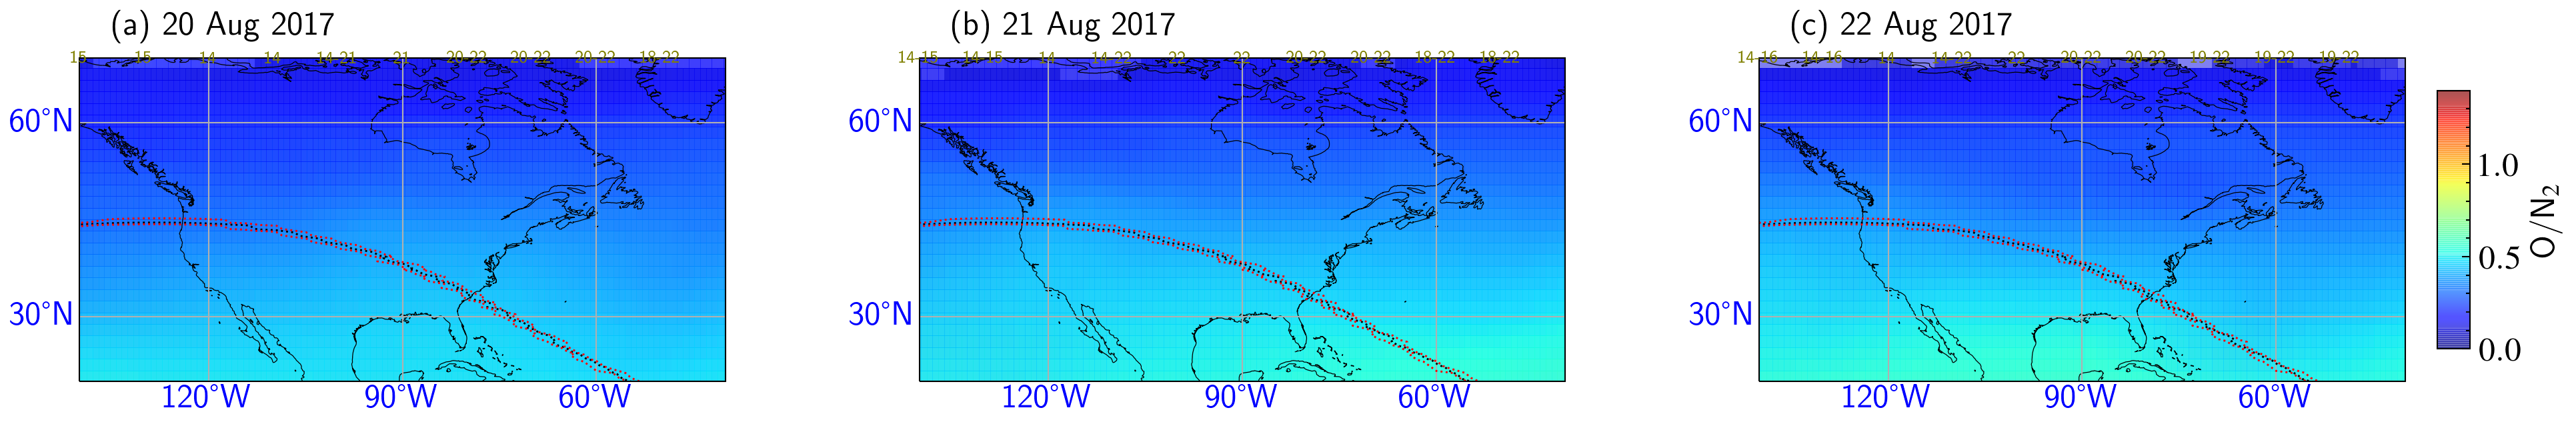

In [7]:
fig = plt.figure(figsize=(15, 2.5), dpi=300)
ax = draw_images(131)
ax.text(0.05, 1.1, "(a) 20 Aug 2017", ha="left", va="center", transform=ax.transAxes)
XYZ = ccrs.PlateCarree().transform_points(ccrs.Geodetic(), lon_20, lat_20)
X, Y = XYZ[:, :, 0], XYZ[:, :, 1]
im = ax.pcolormesh(X, Y, on2_grid_20, transform=ccrs.PlateCarree(), cmap="jet", alpha=0.5, vmin=0, vmax=1.4)
read_lines(ax)
for i, t in enumerate(grid_20["T"]):
    ax.text(
        grid_20["lons"][i],
        70,
        t,
        ha="center",
        va="center",
        transform=ccrs.PlateCarree(),
        fontdict={"size":6,"color":"olive"}
    )

ax = draw_images(132)
ax.text(0.05, 1.1, "(b) 21 Aug 2017", ha="left", va="center", transform=ax.transAxes)
XYZ = ccrs.PlateCarree().transform_points(ccrs.Geodetic(), lon_21, lat_21)
X, Y = XYZ[:, :, 0], XYZ[:, :, 1]
im = ax.pcolormesh(X, Y, on2_grid_21, transform=ccrs.PlateCarree(), cmap="jet", alpha=0.5, vmin=0, vmax=1.4)
read_lines(ax)
for i, t in enumerate(grid_21["T"]):
    ax.text(
        grid_21["lons"][i],
        70,
        t,
        ha="center",
        va="center",
        transform=ccrs.PlateCarree(),
        fontdict={"size":6,"color":"olive"}
    )

ax = draw_images(133)
ax.text(0.05, 1.1, "(c) 22 Aug 2017", ha="left", va="center", transform=ax.transAxes)
XYZ = ccrs.PlateCarree().transform_points(ccrs.Geodetic(), lon_22, lat_22)
X, Y = XYZ[:, :, 0], XYZ[:, :, 1]
im = ax.pcolormesh(X, Y, on2_grid_22, transform=ccrs.PlateCarree(), cmap="jet", alpha=0.5, vmin=0, vmax=1.4)
read_lines(ax)
cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8], transform=ax.transAxes)
cb = fig.colorbar(im, ax=ax, cax=cax)
cb.set_label(r"O/N$_2$")
for i, t in enumerate(grid_22["T"]):
    ax.text(
        grid_22["lons"][i],
        70,
        t,
        ha="center",
        va="center",
        transform=ccrs.PlateCarree(),
        fontdict={"size":6,"color":"olive"}
    )

# on2_grid = np.dstack((on2_grid_19, on2_grid_20, 
#                       on2_grid_22, on2_grid_23,))
# on2_grid = np.mean(on2_grid, axis=2)
# ax = draw_images(324)
# ax.text(0.05, 1.05, "(d) Ratio 20 Aug to [20 \& 22] Aug", ha="left", va="center", transform=ax.transAxes)
# XYZ = ccrs.PlateCarree().transform_points(ccrs.Geodetic(), lon_20, lat_20)
# X, Y = XYZ[:, :, 0], XYZ[:, :, 1]
# im = ax.pcolormesh(X, Y, on2_grid_20/on2_grid, transform=ccrs.PlateCarree(), cmap="coolwarm", alpha=0.5, vmax=1.25, vmin=0.750)
# cax = ax.inset_axes([1.05, 0.1, 0.05, 0.8], transform=ax.transAxes)
# cb = fig.colorbar(im, ax=ax, cax=cax)
# cb.set_label(r"R[O/N$_2$]")
# read_lines(ax)


# ax = draw_images(325)
# ax.text(0.05, 1.05, "(e) Ratio 21 Aug to [20 \& 22] Aug", ha="left", va="center", transform=ax.transAxes)
# XYZ = ccrs.PlateCarree().transform_points(ccrs.Geodetic(), lon_21, lat_21)
# X, Y = XYZ[:, :, 0], XYZ[:, :, 1]
# im = ax.pcolormesh(X, Y, on2_grid_21/on2_grid, transform=ccrs.PlateCarree(), cmap="coolwarm", alpha=0.5, vmax=1.25, vmin=0.750)
# read_lines(ax)

# ax = draw_images(326)
# ax.text(0.05, 1.05, "(f) Ratio 22 Aug to [20 \& 22] Aug", ha="left", va="center", transform=ax.transAxes)
# XYZ = ccrs.PlateCarree().transform_points(ccrs.Geodetic(), lon_22, lat_22)
# X, Y = XYZ[:, :, 0], XYZ[:, :, 1]
# im = ax.pcolormesh(X, Y, (on2_grid_22/on2_grid), transform=ccrs.PlateCarree(), cmap="coolwarm", alpha=0.5, vmax=1.25, vmin=0.750)
# read_lines(ax)

fig.subplots_adjust(wspace=0.3, hspace=0.3)